**Titanic: Machine Learning from Disaster**

**By Stephen Mak**

The Titanic's maiden voyage was on April 15th, 1912, which killed 1502 out of 2224 (67.5%) of the onboard passengers. The intent of this competition is to determine which passengers were likely to survive using various machine learning tools.

The exam question is to **predict if a passenger survived the sinking of the Titanic or not**.

The metric used to evaluate the model will simply be the Rand accuracy. This is simply defined as the sum of True Positives (TP) and True Negatives (TN) divided by the number of examples.

The most crude model would predict everyone to have not survived, regardless of other features. This crude model would achieve an accuracy of 67.5%, and thus this will be the baseline accuracy.

Features available
The response variable will be "Survival" which is a binary yes/no (1 or 0).

Various features are available including:

*  **"PassengerId"** - Unique passenger ID - Categorical
    * Ranges from 1 to XXXX

* **"pclass"**, - Ticket Class - Categorical (1 = 1st Class, 2 = 2nd Class, 3 = 3rd Class)
    * This could be an important feature as the number of lifeboats available to each ticket class may have varied.

*  **"Sex"** - Gender - (Probably) Binary, Categorical variable containing 2 classes, male or female
    * This could be an important feature as it is believed that females and children were advised to leave the boat first.

* **"Age"** - Passenger's age in years - Categorical / Continuous (can decide later)
    * Note that if the age has been estimated, it will finish in "xx.5". Therefore, there is potential for feature engineering to create an "estimated age yes/no" feature. Note also if the age is less than 1 it is fractional.

*  **"sibsp"** - Number of siblings/spouses onboard - Categorical
    * defined as brother/sister/stepbrother/stepsister/husband/wife.

*  **"parch"** - Number of parents/children onboard -Categorical
    * defined as mother/father/daughter/son/stepdaughter/stepson.

*  **"ticket"** - Ticket Number - Categorical / Continuous (can decide later)
    * Has a weird structure. Need to understand

*  **"fare"** - Passenger Fare - Continuous
    * Range from XXXX to XXXX

*  **"cabin"** - Cabin Number - Categorical
    * Need to understand structure

*  **"embarked"** - Port of Embarkation - Categorical
    * C = Cherbourg (France), Q = Queenstown (now Cobh, Ireland), S = Southampton (UK)



**Interesting sidenotes**

* Titanic only had enough lifeboats for 1178 people due to outdated maritime safety regulations.

* Women and children were evacuated first, therefore, it is suspected that this will be crucial for the model.

* RMS Carpathia arrived 2 hours later to save approximately 705 people.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from pathlib import Path

PATH = Path('/kaggle/input/')
TRAIN = PATH/'train.csv'
TEST = PATH/'test.csv'

pd.options.display.max_columns = 20

First, let's read in the data and explore the dataset to better understand the data and what features could be useful for our model.

In [ ]:
columns = ['ID', 'Survived', 'Class', 'Name', 'Sex', 'Age', 'SibSp', 'ParCh', 'TicketNo', 'Price', 'CabinNo', 'EmbarkCity']
columns_test = ['ID', 'Class', 'Name', 'Sex', 'Age', 'SibSp', 'ParCh', 'TicketNo', 'Price', 'CabinNo', 'EmbarkCity']

data = pd.read_csv(TRAIN, names = columns, header=0)
data_test = pd.read_csv(TEST, names = columns_test, header=0)

print(data_test.head())
# print(data.columns)
# print(data.dtypes)
# print(data.head(5))
# print(data.describe(include='all'))
# print(data.count())

cat_features = ['ID', 'Survived', 'Class', 'Name', 'Sex', 'SibSp', 'ParCh', 'TicketNo', 'CabinNo', 'EmbarkCity']
cont_features = ['Age', 'Price']

for feature in cat_features:
    data[feature] = data[feature].astype('category').cat.as_ordered()
    if feature == 'Survived':
        continue
    data_test[feature] = data_test[feature].astype('category').cat.as_ordered()
    
for feature in cont_features:
    data[feature] = data[feature].fillna(data['Age'].median()).astype('float32')
    data_test[feature] = data_test[feature].fillna(data['Age'].median()).astype('float32')

# plt.hist(data['Age'], bins=20)
# plt.show()

# print(data['Age'].describe())
# print(data.dtypes)
# print(data.head(5))

In [ ]:
plt.figure(figsize=(20,10))

plt.scatter(data['Age'], data['Price'])
plt.xlabel('Age (Years)')
plt.ylabel('Price ($)')
plt.title('Price paid per ticket vs. Age')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.lmplot(x='Age', y='Price', data=data, hue='Sex', palette='Set1')
plt.show()

In [ ]:
print(cat_features)
print(cont_features)

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(x='Sex', y='Price', hue='Survived', data=data)
plt.savefig('Price vs. Gender.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(x='Sex', y='Age', hue='Survived', data=data)
plt.savefig('Age vs. Gender.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(x='Class', y='Age', hue='Survived', data=data)
# plt.savefig('Age vs. Class.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(x='EmbarkCity', y='Price', hue='Survived', data=data)
# plt.savefig('Age vs. Class.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(x='SibSp', y='Price', hue='Survived', data=data)
# plt.savefig('Age vs. Class.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

sns.pairplot(data)
plt.show()

In [ ]:
# cov_matrix = data.corr()

# sns.heatmap(cov_matrix)
# plt.show()

**Time to do some feature engineering**

Some features that may be useful for training:
1. Is the passenger a child? i.e. is their age < 18? doesn't have to be 18, this number could change

In [ ]:
data['Survived'] = data['Survived'].astype('float32')

sns.lmplot(x='Age', y='Survived', data=data, logistic=True, palette='Set1', hue='Sex')
plt.show()

The older females had a greater probablility of survival; however, the inverse is true for males???

In [ ]:
age = 18

data['IsChild'] = np.where(data['Age'] <= age, '1', '0')
data_test['IsChild'] = np.where(data_test['Age'] <= age, '1', '0')


data_dummies = pd.get_dummies(data, columns = ['EmbarkCity', 'Sex'])
data_test_dummies = pd.get_dummies(data_test, columns = ['EmbarkCity', 'Sex'])

print(data_dummies.columns)

[0.752      0.832      0.84       0.824      0.76422764]
0.8024455284552845
Index(['ID', 'Class', 'Age', 'SibSp', 'ParCh', 'Price', 'IsChild',
       'EmbarkCity_Q', 'EmbarkCity_S', 'Sex_female'],
      dtype='object')
[[ 1.40295702e-04 -9.07869347e-01 -2.21878600e-02 -3.79404668e-01
  -1.25851453e-01  3.19968667e-03  5.09763125e-01 -2.58196555e-01
  -4.22039118e-01  2.53151320e+00]]


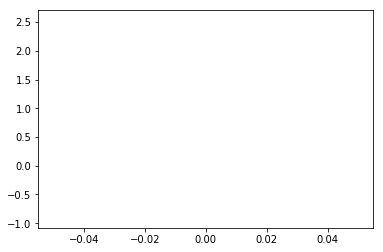

Training Accuracy 	 Validation Accuracy 
 0.812199036918138, 0.8022388059701493


In [83]:
y = data_dummies['Survived'].values
X = data_dummies.drop(columns = ['Survived','Name', 'TicketNo', 'CabinNo', 'EmbarkCity_C', 'Sex_male'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88, stratify=y)

log_regression = LogisticRegression()

cv_results = cross_val_score(log_regression, X_train, y_train, cv=5)

print(cv_results)
print(np.mean(cv_results))

log_regression.fit(X_train, y_train)

print(data_dummies.drop(columns=['Survived','Name', 'TicketNo', 'CabinNo', 'EmbarkCity_C', 'Sex_male'], axis=1).columns)
print(log_regression.coef_)
plt.plot(log_regression.coef_)
plt.show()

y_pred_train = log_regression.predict(X_train)
y_pred_val = log_regression.predict(X_test)

# print(f'Test set predictions:\n {y_pred}')

print(f'Training Accuracy \t Validation Accuracy \n {log_regression.score(X_train, y_train)}, {log_regression.score(X_test, y_test)}')

In [ ]:
y_pred = log_regression.predict(data_test_dummies.drop(columns=['Name', 'TicketNo', 'CabinNo'], axis=1)).astype(int)

submission = pd.DataFrame({'PassengerId': data_test['ID'], 'Survived':y_pred})
submission.to_csv('titanic_pred.csv', index=False)

Why reshape data (-1,1)?

In [ ]:


# print(data.columns)

# plt.plot(x, y, color = 'blue')
# plt.xlabel
# plt.ylabel
# plt.title
# plt.show
# plt.axes([x_lo, y_lo, width, height])
# plt.axis([x_min, x_max, y_min, y_max])
# #Units in figure units, between 0 and 1.
# ​
# plt.subplot(2,1,1)
# #Number rows, number columns, which subplot to make active. Order goes from top to bottom, left to right, indexed from 1.
# plt.tight_layout()
# #Pads spaces between subplots so that there is no overlap
# ​
# plt.annotate()
# plt.style.use()
# plt.style.available()
# ​
# plt.legend()
# ​
# plt.savefig()
# ​
# plt.hist()
# plt.hist2d()
# ​
# plt.hexbin()
# ​
# plt.colorbar()